# Work on the neurons creation

## 1. Loading event

In [1]:
############################### DEPENDENCIES ##################################
import json
import os
import sys
import contextlib
import io
import numpy as np
import inspect
import os.path
import matplotlib.pyplot as plt
from math import pi, atan, sin, sqrt, tanh, cosh, exp, ceil
import seaborn as sns
from numpy.core.fromnumeric import shape
import random
import time
import math
import statistics
from pathlib import Path
from math import atan2, tan, log, cos, sin
from decimal import Decimal

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

project_root = module_path

from event_model import event_model as em
from validator import validator_lite as vl
import data_analysis.event_generator as eg
from visual.color_map import Colormap


In [3]:
########################### HELPER FUNCTIONS ##################################
def get_polar_coordinates(x, y):
    r = math.sqrt(x ** 2 + y ** 2)
    phi = math.atan2(x, y)
    if phi < 0:
        phi = math.pi - phi
    return r, phi

In [4]:
def load_event(file_name, plot_event=False):
# NB: some modifications might have been done for a better understanding
    f = open(file_name)
    json_data_event = json.loads(f.read())

    ev = em.event(json_data_event, read_tracks=True)

    modules = ev.modules
    tracks = ev.real_tracks

    if plot_event:
        eg.plot_tracks_and_modules(tracks, modules, title="Loaded Event")

    modules_even = []
    modules_odd = []

    for i in range(len(modules)):
        if i % 2 == 0:
            modules_even.append(modules[i])
        else:
            modules_odd.append(modules[i])

    return json_data_event, modules_even, modules_odd, tracks, modules

In [5]:
i = 2
event_file_name = "/datasets/minibias/velo_event_"
file_name = project_root + event_file_name
print(file_name)

c:\Users\aurel\Documents\GitHub\Code_Thesis_GitHub\Code_Thesis_GitHub/datasets/minibias/velo_event_


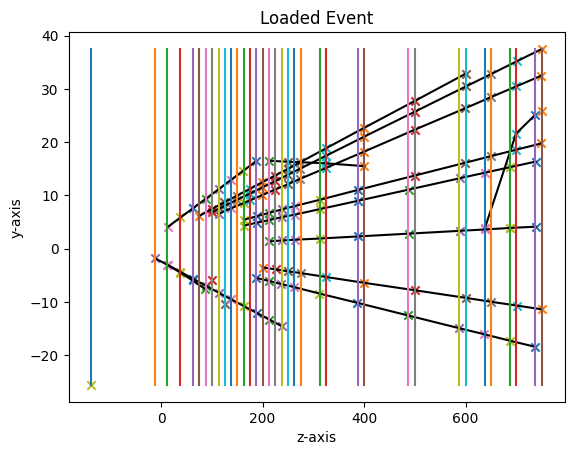

In [6]:
json_data_event, modules_even, modules_odd, tracks, modules = load_event(file_name + str(i) + ".json", plot_event=True)

## 2. Initialize Hopfield

In [77]:
parameters = {
        ### NEURONS ###
        "random_neuron_init": True,
        "binary_states": False,  # try it out once maybe but scrap it
        ### WEIGHTS ###
        "ALPHA": 1,
        "BETA": 10,
        "GAMMA": 10,
        "narrowness": 200,
        "constant_factor": 0.9,
        "monotone_constant_factor": 0.9,
        #### UPDATE ###
        "T": 1e-8,  # try to experiment with these rather
        "B": 1e-4,  # try to experiment with these rather
        "T_decay": lambda t: max(1e-8, t * 0.01),  # try to remove these
        "B_decay": lambda t: max(1e-4, t * 0.04),  # try to remove these
        "decay_off": False,  # using this
        "randomized_updates": True,
        "fully_randomized_updates": False,
        #### THRESHOLD ###
        "maxActivation": True,
        "THRESHOLD": 0.2,
        ##### CONVERGENCE ###
        "convergence_threshold": 0.00000005,
        "bootstrap_iters": 10,
        "bootstrap_method": "below_mean",
        ###### BIFURC REMOVAL #####
        "smart": True,
        "only_weight": False,
        "max_activation": False,
        ###### Track prunning #######
        # here we could set the threshold
        "pruning_tr": 0.01,
    }

In [112]:
p = parameters
m = modules
start_T = p["T"]
start_B = p["B"]
N = None
N_info = None
modules_count = len(modules)
hit_counts = [len(module.hits()) for module in m]

neuron_count = [
    hit_counts[i] * hit_counts[i + 1]
    for i in range(modules_count - 1)
    ]

flips = 0
max_neurons = max(neuron_count)
#init_neurons(tracks=tracks)
#init_weights()
extracted_hits = set()
extracted_tracks = []
extracted_track_states = []
energies = []

## 3. Work on the neurons creation

In [113]:
print(modules_count)
print(max_neurons)

print('hit count:',len(hit_counts))

print('len neuron count:',len(neuron_count))

layers = modules_count -1
print(layers)

52
10816
hit count: 52
len neuron count: 51
51


In [114]:
def init_neurons(tracks: list = None):
        # consider hits inbetween 2 modules as one neuron layer
        # the neurons in N are ordered h(1,1)-h(2,1); h(1,1)-h(2,2); h(1,1)-h(2,3) etc
        
        if p["random_neuron_init"]:
            N = np.random.uniform(size=(modules_count - 1, max_neurons))
            
        else:
            N = np.ones(shape=(modules_count - 1, max_neurons))

        if tracks:
            N = np.zeros(shape=(modules_count - 1, max_neurons))
            
        for idx, nc in enumerate(neuron_count):  
            #idx is a simple index from 0 to 34 (neuron_count is 35)
            #nc is the value of neuronns count for that index ex: [0,1], [1,3], ..., [34,20] 
            # > in layer 0, we have 1 neurons, in layer 2, we have 3 neurons
            N[idx, nc:] = 0
            # this  sets the value of N matrix to zero for elements after neuron_count[idx] in each row idx of N, 
            # effectively limiting the number of neurons in each layer to the corresponding value in neuron_count[idx].


        N_info = np.zeros(shape=(modules_count - 1, max_neurons, 4))
        
        for idx in range(modules_count - 1):
            m1 = m[idx]       #first module i
            m2 = m[idx + 1]   #second module i+1

            for i, hit1 in enumerate(m1.hits()):
                for j, hit2 in enumerate(m2.hits()):
                    # crossing all hits i in module 1 with all hits j in module 2

                    n_idx = i * hit_counts[idx + 1] + j 
                    
                    if tracks:
                        for t in tracks:
                            if hit1 in t and hit2 in t:
                                N[idx, n_idx] = 1 #activate the neuron
                                
                    # maybe we can check these angles again
                    angle_xz = atan((hit2.x - hit1.x) / (hit2.z - hit1.z))
                    angle_yz = atan((hit2.y - hit1.y) / (hit2.z - hit1.z))
                    norm_dist = sqrt(
                        (hit2.y - hit1.y) ** 2 + (hit2.x - hit1.x) ** 2
                    ) / sqrt(
                        (hit2.z - hit1.z) ** 2
                    )  # does not work!!!

                    _, r_hit1 = get_polar_coordinates(hit1.x, hit1.y)
                    _, r_hit2 = get_polar_coordinates(hit2.x, hit2.y)
                    monotone_dist = (r_hit2 - r_hit1) / (hit2.z - hit1.z)

                    N_info[idx, n_idx, 0] = abs(angle_xz)
                    N_info[idx, n_idx, 1] = abs(angle_yz)
                    N_info[idx, n_idx, 2] = norm_dist  # not robust!!!!
                    N_info[idx, n_idx, 3] = monotone_dist

In [141]:
N = np.random.uniform(size=(layers, max_neurons))

for idx, nc in enumerate(neuron_count):  
            # idx is a simple index from 0 to 37 (len(neuron_count) is 38)
            # nc is the number of neurons in each layer
            # we obtain [0,0], [1,0], ..., [13,6], ..., [37,20] 
            #  > in layer 0, we have 0 neurons, in layer 13, we have 6 neurons, in layer 37 we have 20 neurons
            #print(idx,nc)
            N[idx, nc:] = 0

print(shape(N))
print(hit_counts)

(51, 10816)
[91, 96, 91, 96, 92, 105, 97, 104, 104, 93, 85, 94, 84, 77, 90, 71, 81, 70, 97, 74, 93, 68, 93, 67, 106, 79, 102, 76, 102, 85, 94, 79, 96, 77, 98, 87, 100, 89, 98, 93, 81, 103, 87, 85, 87, 85, 86, 84, 90, 88, 88, 84]


In [142]:

N_info = np.zeros(shape=(layers, max_neurons, 4))
        
for idx in range(layers):     #from 0 to 37
            m1 = m[idx]       #first module i
            m2 = m[idx + 1]   #second module i+1


             #print(m1.hits(),'\n')

            for i, hit1 in enumerate(m1.hits()): # for each hit in modoule i 
                # i is used to index the hit INSIDE of the module (i.e, module with 3 hits, index from 0 to 2)
                # hit1 gives the information about the i hit in module idx which are [hit id, module number, x, y, z] 
                for j, hit2 in enumerate(m2.hits()):
                    # crossing all hits i in module 1 with all hits j in module 2
                    # j is used to index the hit INSIDE of the module (i.e, module with 3 hits, index from 0 to 2)
                    # hit2 gives the information about the j hit in module idx+1 which are [hit id, module number, x, y, z] 
                
                    n_idx = i * hit_counts[idx + 1] + j 
                    #print(i, hit_counts[idx + 1], j)

                    if tracks:
                        for t in tracks:
                            if hit1 in t and hit2 in t:
                                N[idx, n_idx] = 1 #activate the neuron

                    # maybe we can check these angles again
                    angle_xz = atan((hit2.x - hit1.x) / (hit2.z - hit1.z))
                    angle_yz = atan((hit2.y - hit1.y) / (hit2.z - hit1.z))
                    
                    norm_dist = sqrt((hit2.y - hit1.y) ** 2 + (hit2.x - hit1.x) ** 2 + (hit2.z - hit1.z) ** 2)  # does not work!!!

                    _, r_hit1 = get_polar_coordinates(hit1.x, hit1.y)
                    _, r_hit2 = get_polar_coordinates(hit2.x, hit2.y)
                    monotone_dist = (r_hit2 - r_hit1) / (hit2.z - hit1.z)

                    N_info[idx, n_idx, 0] = abs(angle_xz)
                    N_info[idx, n_idx, 1] = abs(angle_yz)
                    N_info[idx, n_idx, 2] = norm_dist  # not robust!!!!
                    N_info[idx, n_idx, 3] = monotone_dist

In [138]:
def eta_pseudorapidity(point1,point2):
    eta_list=[0.01]
    angle_yz = atan2((point2.y- point1.y),(point2.z - point1.z))
    try:
        eta = -(log(Decimal((sin(angle_yz/2) ** 2)/(cos(angle_yz/2) ** 2))))
        eta_list.append(eta)
    except ValueError:
        eta = sum(eta_list)/len(eta_list)
    return eta


2.5575488952520753
401970


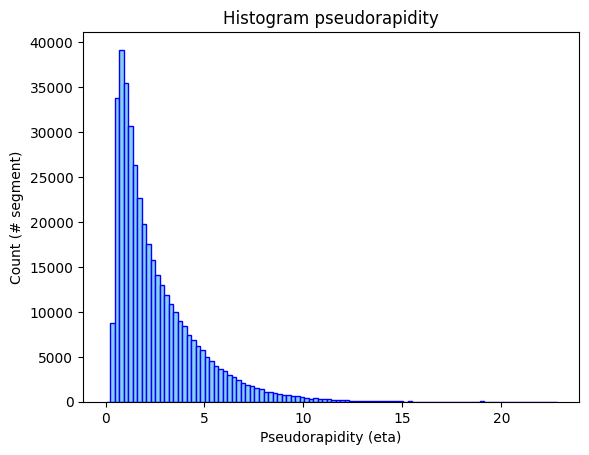

In [139]:
pseudorapidity_eta_list=[]

for idx in range(layers):     #from 0 to 37
            m1 = m[idx]       #first module i
            m2 = m[idx + 1]   #second module i+1


             #print(m1.hits(),'\n')

            for i, hit1 in enumerate(m1.hits()): # for each hit in modoule i 
                # i is used to index the hit INSIDE of the module (i.e, module with 3 hits, index from 0 to 2)
                # hit1 gives the information about the i hit in module idx which are [hit id, module number, x, y, z] 
                for j, hit2 in enumerate(m2.hits()):
                    eta = eta_pseudorapidity(hit1,hit2)
                    #angle_yz = atan2((hit2.y- hit1.y),(hit2.z - hit1.z))
                    #step1 = Decimal((sin(angle_yz/2) ** 2)/(cos(angle_yz/2) ** 2))
                    #eta = -0.5*(log(step1))
                    pseudorapidity_eta_list.append(eta)
                    #mean = sum(pseudorapidity_eta_list)/len(pseudorapidity_eta_list)

print(len(pseudorapidity_eta_list))

plt.hist(pseudorapidity_eta_list,color = "skyblue", edgecolor='blue',bins=100)
plt.xlabel('Pseudorapidity (eta)')
plt.ylabel('Count (# segment)')
plt.title('Histogram pseudorapidity')
plt.show()